# CSE527 Homework 3
**Due date: 23:59 on 11/06, 2018 (Tuesday)**

## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 15 categories by training and testing on the 15
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---
The starter code trains and tests on 100 images from each category (i.e. 1500
training examples total and 1500 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.
Download the dataset
[here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing). <br>

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder,
there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Delete** the data subfolder before submission or the blackboard won't let you do so because
of the size. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.6% accuracy
(1 out of 15 guesses is correct).

In [14]:
# import packages here
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score 
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix

In [ ]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset('data/test/', 100)
test_num = len(test_label)

# feature extraction
def extract_feat(raw_data):
    feat_dim = 1000
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
        
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(15) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in xrange(test_num):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(test_num)

print "The accuracy of my dummy model is {:.2f}%".format(accuracy*100)

## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [20]:
##Tiny images plus nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))
np.seterr(divide='ignore', invalid='ignore')

##Function to normalize the image
#Input: Image(numpy array)
#Output: Normalized image(numpy array)
def normalize_image(img):
    mean = np.mean(img)
    std = np.sqrt((img - mean)**2)
    norm = (img - mean)/std
    return norm
    
##Function to load the images and resize them according to the requirement.
#Input: File path
#Output: Input data in the form of tiny image representations and corresponding labels
def tiny_images(path, num_per_class=-1):
    tiny_images_data = []
    #tiny_images_data = np.asarray(tiny_images_data)
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        for filename in img_path_class:
            img = cv2.imread(filename,0)
            res = cv2.resize(img,(16,16), interpolation = cv2.INTER_AREA)
            #res_norm = normalize_image(res)
            tiny_images_data.append(res)
    return tiny_images_data, labels

##Function to rehape the input image numpy array to the desired shape
#Input: Image(numpy array)
#Output: Reshaped image(numpy array)
def reshape(data):
    data = np.array(data)
    nsamples,nx,ny = data.shape
    new_data = data.reshape((nsamples, nx*ny))
    return new_data

#Function to train the Nearest Neighbour classifier and predict the labels of the test data set
#Input: training data, testing data, training labels and testing labels
#Output: Accuracy and predicted labels
def predict(train_data, train_labels, test_data, test_labels):
    neigh = KNeighborsClassifier(weights='distance',p=2)
    neigh.fit(train_data,train_labels)
    labels_predicted = neigh.predict(test_data)
    accuracy = neigh.score(test_data, test_labels)
    return accuracy, labels_predicted

def getTime(time):
    sec = timedelta(seconds = time)
    d = datetime(1,1,1) + sec
    print("Time required for the process:")
    print("Days:Hours:Minutes:Seconds")
    print("%d:%d:%d:%d" % (d.day-1, d.hour, d.minute, d.second))

start_time1 = time.time()
train_data,train_labels = tiny_images('data/train/')
test_data, test_labels = tiny_images('data/test/')

train_data_new = reshape(train_data)
test_data_new = reshape(test_data)

accuracy1, predicted1 = predict(train_data_new, train_labels, test_data_new, test_labels)
end_time1 = time.time()
total_time1 = end_time1 - start_time1
print("The predicted accuracy is {:.2f}%").format(accuracy1*100)
getTime(total_time1)

The predicted accuracy is 21.57%
Time required for the process:
Days:Hours:Minutes:Seconds
0:0:0:7


## Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [3]:
##Bag of SIFT representations
test_descriptor = []
test_keypoint = []

descriptor = []
keypoints = []

class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

##Function to load the images and resize them according to the requirement.
#Input: File path
#Output: Input data and labels
def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

##Function to calculate the keypoints and descriptors using SIFT
#Input: Image
#Output: Keypoints and descriptors
def get_descriptors(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp,des = sift.detectAndCompute(img, None)
    return kp, des

##Function to stack the descriptors vertically and reshape the descriptors to 
##desired dimensions to be given as an input
#Input: Descriptors
#Output: Vertically stacked descriptors(N*128)
def gen_descriptors(descriptor):
    gen_des = descriptor[0][1]
    for i in descriptor[1:]:
        gen_des = np.vstack((gen_des,i))
    return gen_des

##Function used to generate a grid of keypoints on the image
##also known as densely sampled keypoints. The keypoints are generated at a 
##step size over the image.
#Input: step_size and image
#Output: Descriptors for the generated keypoints
def genDenseSampled(step_size,img1):
    w, h = img1.shape[:2]
    for i in range(step_size, w-step_size, step_size):
        for j in range(step_size, h-step_size, step_size):
            keypoints.append(cv2.KeyPoint(j,i,step_size))
    sift = cv2.xfeatures2d.SIFT_create()
    kp,des = sift.compute(img1,keypoints)
    return np.array(des)

##Function to calculate the time taken for the process to end
#Input: Time in seconds
#Output: Time in Days:Hours:Mins:Secs format
def getTime(time):
    sec = timedelta(seconds = time)
    d = datetime(1,1,1) + sec
    print("Time required for the process:")
    print("Days:Hours:Minutes:Seconds")
    print("%d:%d:%d:%d" % (d.day-1, d.hour, d.minute, d.second))

image_data1,labels1= load_dataset('data/train/')
data_test, labels = load_dataset('data/test/')

start = time.time()
for i in range(len(image_data1)):
    kp,des = get_descriptors(image_data1[i])
    descriptor.append(des)
descriptor = np.array(descriptor)

for i in range(len(data_test)):
    kp1,des1 = get_descriptors(data_test[i])
    test_descriptor.append(des1)
test_descriptor = np.array(test_descriptor)

train_descriptors = gen_descriptors(descriptor)
test_descriptors = gen_descriptors(test_descriptor)

#Calling the KMeans classifier to get the cluster centers
kmeans = MiniBatchKMeans(n_clusters = 75).fit(train_descriptors)
end = time.time()
total_time2 = end - start
#print("Time required:", total_time)
getTime(total_time2)

Time required for the process:
Days:Hours:Minutes:Seconds
0:0:14:16


In [4]:
##Saving the cluster centers to an output file
cluster_centers = kmeans.cluster_centers_
np.save('minkmeanscc75.npy', cluster_centers)

In [5]:
##Read the data from the file and input it to the classifier. Fit the classifier again
cluster_centroids = np.load('minkmeanscc75.npy')
kmeans = MiniBatchKMeans(n_clusters = 75, init = cluster_centroids, n_init=1)
kmeans.fit(train_descriptors)

MiniBatchKMeans(batch_size=100, compute_labels=True,
        init=array([[16.3886 , 22.96779, ..., 15.50582, 13.77467],
       [21.43563, 19.13423, ..., 17.05757,  8.29348],
       ...,
       [21.01293, 13.86225, ..., 11.46013, 17.59258],
       [24.20321,  7.85551, ...,  7.70054,  8.09619]], dtype=float32),
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=75,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [7]:
##Function to generate the Histogram for image data from 
##the available descriptors and the cluster centers
#Input: Image data, descriptors, number of cluster centers
#Output: Histogram of descriptor frequency vs cluster index
def gen_histogram(image_data1, descriptor,n_clusters):
    im_features = np.zeros((len(image_data1),n_clusters))
    for i in range(len(descriptor)):
        for j in (descriptor[i]):
            j = np.reshape(np.array(j),(1,-1))
            #Calculating the cluster index using our pretrained classifier
            index = kmeans.predict(j)
            #Appending the histogram at the coordinates 
            im_features[i][index] += 1
    return im_features

##Function to normalize the Histogram
#Input: Histogram
#Output: Normalized Histogram
def standardizer(input_features):
    stdSlr = StandardScaler().fit(input_features)
    input_features = stdSlr.transform(input_features)
    return input_features

start1 = time.time()
train_features = gen_histogram(image_data1, descriptor,75)
test_features = gen_histogram(data_test, test_descriptor,75)

train_features_input = standardizer(train_features)
test_features_input = standardizer(test_features)

end1 = time.time()
total_time3 = end1 - start1
getTime(total_time3)

Time required for the process:
Days:Hours:Minutes:Seconds
0:0:11:55


In [9]:
##Function used to train and predict the labels for the test data using Nearest neighbors classifer
#Input: training and test data in the form of normalized histograms and the corresponding labels
#Output: predicted labels and accuracy
def KNN(train_data, train_labels, test_data, test_labels):
    neigh = KNeighborsClassifier(n_neighbors=12, weights='distance',p=2)
    neigh.fit(train_data, train_labels)
    labels_predicted = neigh.predict(test_data)
    accuracy1 = neigh.score(test_data, test_labels)
    return labels_predicted, accuracy1

start2 = time.time()
predicted2, accuracy2 = KNN(train_features_input, labels1, test_features_input, labels)
end2 = time.time()
total_time4 = end2 -start2
print("The predicted accuracy is {:.2f}%").format(accuracy2*100)
getTime(total_time4)

The predicted accuracy is 44.79%
Time required for the process:
Days:Hours:Minutes:Seconds
0:0:0:1


## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{20 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 15-way classification problem
(the library has handled it for you). To decide which of 15 categories a test
case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: 10 points will be given to students whose accuracy
  ranks top 3 in this homework. Don't cheat and don't train your model on
  testing data, a separate testing dataset will be used to evaluate your model.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [12]:
##Function used to train and predict the labels for the test data using Linear Support vector machine classifer
#Input: training and test data in the form of normalized histograms and the corresponding labels
#Output: predicted labels and accuracy
def SVM(train_data, train_labels, test_data, test_labels):
    clf =  OneVsRestClassifier(LinearSVC(random_state=None ,tol=1e-4, loss='squared_hinge', C=0.012))
    clf.fit(train_data,train_labels)
    labels_predicted = clf.predict(test_data)
    accuracy = accuracy_score(test_labels, labels_predicted)
    return labels_predicted, accuracy

start3 = time.time()
predicted3, accuracy3 = SVM(train_features_input, labels1, test_features_input, labels)
end3 = time.time()
total_time5 = end3-start3
print("The predicted accuracy is {:.2f}%").format(accuracy3*100)
getTime(total_time5)

The predicted accuracy is 48.84%
Time required for the process:
Days:Hours:Minutes:Seconds
0:0:0:0


## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%). <br>

**First combination:** <br>

-- **Time consumed and prediction accuracy:**

Time consumed: 6 seconds

The time consumed includes entire process of reading the data,processing it, training and testing


**Prediction accuracy: 21.57%**
The classifier which has been used is the K Nearest Neighbors. The parameters which have been tuned to increase the performance in accuracy are ‘weights’ and ‘p’.

The value of ‘p’ which is the power parameter has been selected as 2. This specifies that the Minkowski metric to be used is the ‘Euclidean distance’

The ‘weights’ parameter has been set to ‘distance’; this means that the neighbors near to the point under consideration have a greater influence than the neighbors which are further away.



-- **Algorithm descriptions and discussions**

The training and the testing images were both first resized to size 16*16. This results in the input array of the shape (N,16,16) where N is the number of the images. This input array is then reshaped into (N*256) before passing it to the classifier. This operation has been performed for both the testing and training images.
Although this algorithm is computationally very fast the accuracy is pretty low.


-- **Confusion matrix observations**

From the confusion matrix we can see that the model has performed well for Suburb and Kitchen category relatively but poorly for all the other categories. This is reflective of the extremely low accuracy.

**Second combination:** <br>

--**Time consumed and prediction accuracy**

Time Consumed for training data preprocessing: 14:16 minutes
The data preprocessing in this problem includes loading the images and calculating the key points and SIFT descriptors for each of the image, stacking the descriptors vertically, generating the clusters for the training data.

Time consumed for generating the histograms and normalizing them: 11:55 minutes
The histograms are generated and normalized for each image considering the descriptors and the clusters they lie in.

Time Consumed for training and prediction: 1 second
This is the time required for training the training data to with the Nearest Neighbor Classifier and then predicting the labels for the test data.

**Prediction Accuracy: 44.79%**

To decrease the computation time and increase the accuracy I have made use of the Mini-batch K-Means classifier instead of the K-Means classifier for clustering. The major reason being the large number of input samples to the classifiers. The number of clusters which I have used is 75. I have experimented with cluster sizes 50, 100, 150 and 200. I got the best results for 75 clusters. 

For the K Nearest Neighbors classifier for prediction the parameters I have tuned for the best output accuracy are ‘n_neighbors’, ‘weights’ and ‘p’.
The ‘weights’ and the ‘p’ parameters are set to ‘distance’ and ‘2’ respectively for the reasons mentioned in the previous problem.
I experimented with the value for ‘n_neighbors’ and got the best accuracy for the value ‘12’



-- **Algorithm descriptions and discussions**

The first step in the implementation is loading the data and generating SIFT descriptors for the images. To generate the SIFT descriptors we need keypoints. I experimented with two different methods for generating the keypoints: 


--Generate a grid of densely sampled keypoints throughout the image with a desired step size.

--‘siftDetectAndCompute’

To generate the densely sampled keypoints I used the function shown below and collected keypoints at different pixel locations separated a by a constant/uniform step size. The coordinates are converted into keypoints using the cv2.Keypoint object

I then used siftCompute()’ to generate the descriptors for these keypoints. However I got a low accuracy for this process. Mainly because I selected points and discarded the others which could have been more ‘descriptive’. Also the time taken for this process was too long.

Step Sizes experimented with: 5, 10, 15, 20. I have therefore used ‘siftDetectAndCompute()’ for generating the keypoints and the descriptors. I have used all the descriptors for getting a higher accuracy.

The second step in the implementation of this algorithm cluster center computing. For clustering the descriptors are stacked vertically which gives an array of dimension N*128, where N is a very large number and 128 because the dimension of a SIFT object is 128. The cluster centers has been computed using ‘MiniBatchKMeans’ classifier with 75 cluster centers mainly because of it gave me better accuracy and took less time than the equivalent ‘KMeans’.

The third step in this problem implementation is the generation of the histogram for our training and testing data. This histogram is our input to the classifier. The histogram is basically the distribution of the various descriptors found in the image and the category of cluster they fall into. To create a histogram, for all the descriptors I predicted the cluster index they fall into and then appended their occurence in a 1500*N array, where N is the number of clusters. I used the following function to generate the histogram:

The last step is training the classifier and predicting the test data labels



**-- Confusion matrix observations**

The classifier has performed well for the Suburb, Forest, and Tall Building. It has performed relatively well for the other categories as well. This may be because of the use of better classifiers.


**Third combination:** <br>

**-- Time consumed and prediction accuracy**

Time Consumed for training data preprocessing: 14:16 minutes
The data preprocessing in this problem includes loading the images and calculating the key points and SIFT descriptors for each of the image, stacking the descriptors vertically, generating the clusters for the training data.

Time consumed for generating the histograms and normalizing them: 11:55 minutes
The histograms are generated and normalized for each image considering the descriptors and the clusters they lie in.

Time Consumed for training and prediction: <1 second 
This is the time required for training the OneVSRestClassifier and the LinearSVC. And predicted the labels of the test data set.

**Prediction accuracy: 48.84%**

I have used the OneVsRestClassifier along with the LinearSVC for training and prediction. The LinearSVC has a parameter ‘multi_class’ for one vs all classifier. The parameters which I have tuned are ‘loss’ and the ‘C’ parameter. I have set the ‘loss’ parameter to ‘squared-hinge’ and the value of ‘C’ is 0.012


**-- Algorithm descriptions and discussions**

The first three steps are the same as the same input has been used for the second classifier. I experimented with ‘KMeans’ and ‘MiniBatchKMeans’ with cluster size 50, 75, 100, 150 and 200 but got the lowest accuracy for ‘MiniBatchKMeans’ with 75 clusters.


**-- Confusion matrix observations**

The classifier has performed well in predicting TallBuilding category relatively. But as the diagonal elements are more prominent, it has performed well overall. 

Normalized confusion matrix


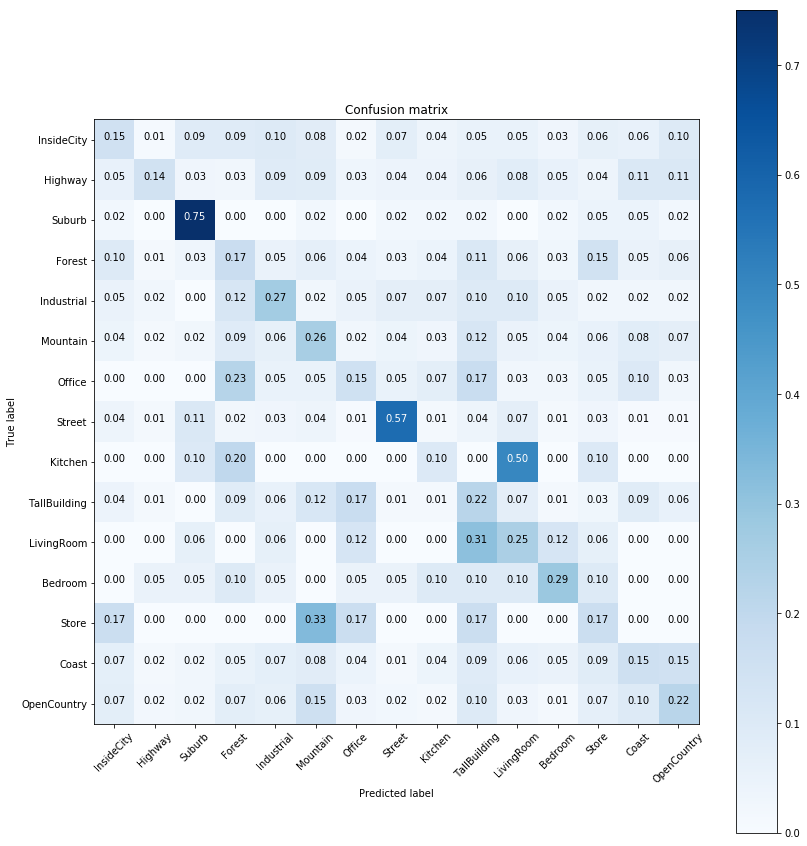

Normalized confusion matrix


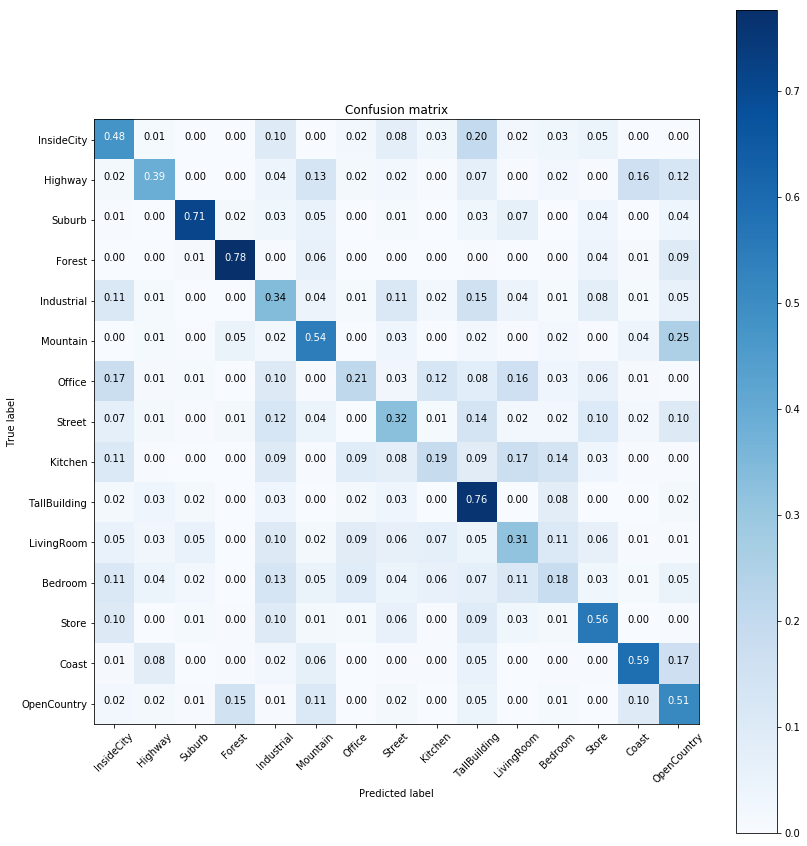

Normalized confusion matrix


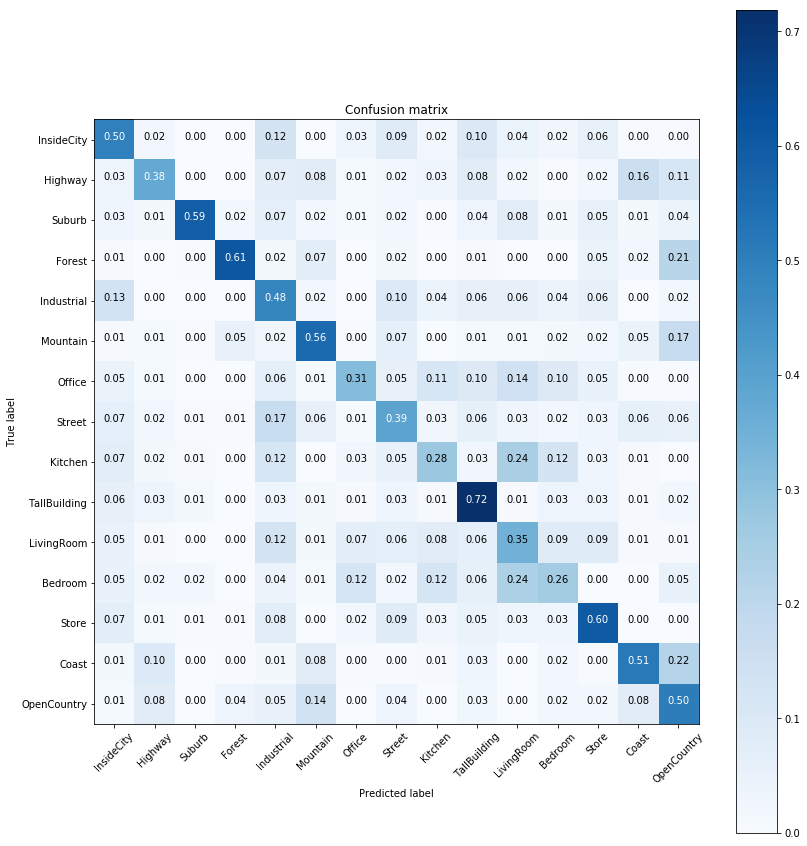

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

c_names = [name[11:] for name in glob.glob('data/train/*')]

#First combination:
# Confusion matrix
cm1 = confusion_matrix(predicted1, test_labels)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True)
plt.show()

#Second combination:
# Confusion matrix
cm2 = confusion_matrix(predicted2, labels)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True)
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(predicted3, labels)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True)
plt.show()

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>